In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.stats
from scipy.optimize import minimize
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
import operator
from scipy.optimize import minimize
import math
import multiprocessing #import Pool
from itertools import count

In [3]:
def gen_dx_recursive(mu_real,sig_real,dt,N):
    N=np.int64(N)
    X = np.zeros((N))
    X[0]=0.5
    #p=0.5 + 0.5*np.sin(np.linspace(0,2*math.pi,N))
    dW=np.sqrt(dt)*np.random.normal(0, 1, N)
    e = np.zeros((N))
    for i in range(1,N):
        b= sig_real*X[i-1]*(1-X[i-1])
        a= mu_real*(0.5 - X[i-1])
        X[i]= X[i-1]+ a*dt+ b*dW[i-1]
    return(X)

In [4]:
def liklihood(param,data, disc):
    L=0
    X=data
    N,dt=disc;
    N=np.int64(N)
    mu,sig =param;
    for i in range(1,N):
        b= sig*X[i-1]*(1-X[i-1])
        a= mu*(0.5 - X[i-1])
        L = L  - (X[i]-X[i-1]-a*dt )**2/(2*dt*b**2) -0.5*np.log(2*math.pi*b**2*dt)
    return(-1*L)

In [5]:
def gen_paths(mu_real,sig_real,dt,N,num_paths=1):
    L = np.zeros((num_paths,N))
    for i in range(0,num_paths):
        L[i]=gen_dx_recursive(mu_real,sig_real,dt,N)
    return(L)

In [6]:
def covergence_test(disc ,param_real, param_initial):
    
    N,dt=disc;
    mu_real,sig_real=param_real
    mu_initial,sig_initial=param_initial
    
    e=gen_dx_recursive(mu_real,sig_real,dt,N)
    
    args=(e,disc)
    x0=param_initial
    bnds = ((None, None), (1e-5, None))
    
    min_param=minimize(liklihood,x0,args,bounds=bnds);min_param
    #min_param=minimize(liklihood,x0,args,method='SLSQP',bounds=bnds,\
                   #tol=1e-24,options={  'ftol': 1e-24,  'eps': 1e-12});min_param
    error = np.divide ( abs(min_param.x - param_real),param_real )
    
    return(min_param.x, error)

In [7]:
#varying number of samples

def convergence_in_N(N_test,fix_dt,param_real_test,param_initial_test):

    err_fixeddt=np.zeros((len(N_test),2))
    result_fixeddt=np.zeros((len(N_test),2))

    for i in range(0,len(N_test)):
        disc_test=np.array([N_test[i],fix_dt])
        result_fixeddt[i,:],err_fixeddt[i,:]=covergence_test(disc_test,param_real_test,param_initial_test)
        
    return(result_fixeddt,err_fixeddt)

In [8]:
#varying number of paths

def convergence_in_L(N_test,fix_dt,param_real_test,param_initial_test,num_paths ):
    result_fixeddt= np.zeros(( num_paths ,len(N_test),2))
    err_fixeddt= np.zeros(( num_paths ,len(N_test),2))

    for i in range(0,num_paths):
        result_fixeddt[i,:,:],err_fixeddt[i,:,:]=convergence_in_N(N_test,fix_dt,param_real_test,param_initial_test)
    return(result_fixeddt, err_fixeddt)

In [9]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', label='slope='+str(slope))

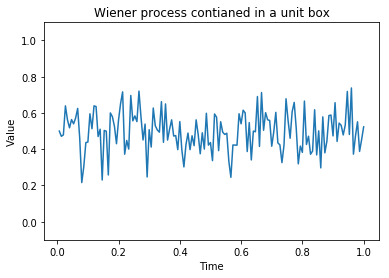

In [10]:
N=150
y=gen_dx_recursive(mu_real=1,sig_real=0.5,dt=1,N=N)
plt.title('Wiener process contianed in a unit box')
plt.ylim((-0.1,1.1))
x_axis=np.divide(np.arange(1,N+1),N)
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(x_axis,y)
plt.savefig('Wiener_box.pdf')

In [91]:
#convergence for increasing number of paths and samples

N_test=np.array([10,100,1000]) #,100,500,1000,10000,50000

fix_dt=1
param_real_test=np.array([0.1,0.01])
param_initial_test= np.array([0.5,0.03])

num_paths_test=np.array([2,10,100,1000]) #,1000,10000


result_fixeddt_avg=np.zeros((len(num_paths_test),len(N_test),2))
err_fixeddt_avg=np.zeros((len(num_paths_test),len(N_test),2))

for i in range(0,len(num_paths_test)):
    result_fixeddt,_=convergence_in_L(N_test,fix_dt,param_real_test,param_initial_test,num_paths_test[i] )
    #obtain averaging estimator
    result_fixeddt_avg[i]=np.average(result_fixeddt, axis=0)
    #error estimates
    err_fixeddt_avg[i,:,0] = np.divide ( abs(result_fixeddt_avg[i,:,0] - param_real_test[0]), param_real_test[0] )
    err_fixeddt_avg[i,:,1]= np.divide ( abs(result_fixeddt_avg[i,:,1] - param_real_test[1]), param_real_test[1] )

In [91]:
#convergence for increasing number of paths and samples

N_test=np.array([10,100,1000]) #,100,500,1000,10000,50000

fix_dt=1
param_real_test=np.array([0.1,0.01])
param_initial_test= np.array([0.5,0.03])

num_paths_test=np.array([2,10,100,1000]) #,1000,10000


result_fixeddt_avg=np.zeros((len(num_paths_test),len(N_test),2))
err_fixeddt_avg=np.zeros((len(num_paths_test),len(N_test),2))

counter=np.nditer(np.arange(1, len(num_paths_test)+1 ),op_dtypes=int)


for i in range(0,len(num_paths_test)):
    
    
    result_fixeddt,_=convergence_in_L(N_test,fix_dt,param_real_test,param_initial_test,num_paths_test[i] )
    #obtain averaging estimator
    result_fixeddt_avg[i]=np.average(result_fixeddt, axis=0)
    #error estimates
    err_fixeddt_avg[i,:,0] = np.divide ( abs(result_fixeddt_avg[i,:,0] - param_real_test[0]), param_real_test[0] )
    err_fixeddt_avg[i,:,1]= np.divide ( abs(result_fixeddt_avg[i,:,1] - param_real_test[1]), param_real_test[1] )

In [63]:
N_test=np.array([10,100]) #,100,500,1000,10000,50000

fix_dt=1
param_real_test=np.array([0.1,0.01])
param_initial_test= np.array([0.5,0.03])

num_paths_test=np.array([2,10,100]) #,1000,10000

if __name__ == '__main__':
    processes = []
    for i in range(0,len(num_paths_test)):
        p = Process(target=convergence_in_L, args=(N_test,fix_dt,param_real_test,param_initial_test,num_paths_test[i]))
        p.start()
        processes.append(p)
    map(lambda p: p.join(), processes)
    


In [89]:
processes

[<Process(Process-33, stopped)>,
 <Process(Process-34, stopped)>,
 <Process(Process-35, closed)>]

In [96]:
C= map(lambda p: p.join(), processes)

In [95]:
print(processes[2])

<Process(Process-35, closed)>


In [83]:
#Example iterator and multiprocessing
pool = multiprocessing.Pool(10)

def f(x):
    return(x+x)

num_paths_test=np.array([2,10,100]) #,1000,10000

counter=np.nditer(np.arange(1, 10+1 ),op_dtypes=int)
ans=np.asarray(pool.map(f, list(counter) )  )

Process ForkPoolWorker-41:
Process ForkPoolWorker-39:
Process ForkPoolWorker-40:
Process ForkPoolWorker-44:
Process ForkPoolWorker-45:
Process ForkPoolWorker-43:
Process ForkPoolWorker-38:
Process ForkPoolWorker-36:
Traceback (most recent call last):
Process ForkPoolWorker-42:
Process ForkPoolWorker-37:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/alhaddwt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/alhaddwt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/alhaddwt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/alhaddwt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/alhaddwt/anaconda3/lib/python3.7/multiprocessi

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/alhaddwt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/alhaddwt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/alhaddwt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/alhaddwt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/alhaddwt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/alhaddwt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/alhaddwt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap


KeyboardInterrupt: 

In [111]:
def f(x):
    return(x+x)

if __name__ == '__main__':
    proc = []
    num_paths_test=np.array([2,10,100]) #,1000,10000
    
    for i in range(0,len(num_paths_test)):
        p = Process(target=f,args=(num_paths_test[i]) )
        p.start()
        proc.append(p)
    map(lambda p: p.join(), proc)

TypeError: 'numpy.int64' object is not iterable

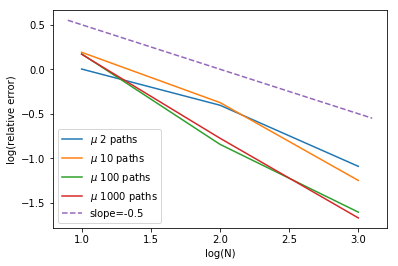

In [92]:
plt.title('')
plt.xlabel('log(N)')
plt.ylabel('log(relative error)')
for i in range(0, len(num_paths_test)):
    mu_label='$\mu$ '+ str(num_paths_test[i]) +' paths'
    sig_label='$\sigma$ '+ str(num_paths_test[i]) +' paths'
    plt.plot(np.log10(N_test),  np.log10(err_fixeddt_avg[i,:,0]), label=mu_label)
    #plt.plot(np.log10(N_test),  np.log10(err_fixeddt_avg[i,:,1]) , label=sig_label)
abline(-0.5,1)
plt.legend()
plt.savefig('wiener_box_mu.pdf')

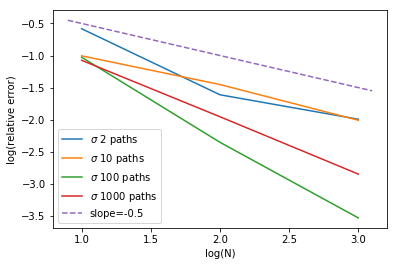

In [93]:
plt.title('')
plt.xlabel('log(N)')
plt.ylabel('log(relative error)')
for i in range(0, len(num_paths_test)):
    mu_label='$\mu$ '+ str(num_paths_test[i]) +' paths'
    sig_label='$\sigma$ '+ str(num_paths_test[i]) +' paths'
    #plt.plot(np.log10(N_test),  np.log10(err_fixeddt_avg[i,:,0]), label=mu_label)
    plt.plot(np.log10(N_test),  np.log10(err_fixeddt_avg[i,:,1]) , label=sig_label)
abline(-0.5,0)
plt.legend()
plt.savefig('wiener_box_sig.pdf')

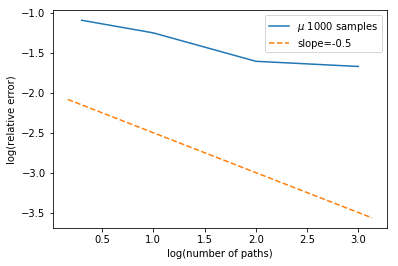

In [94]:
plt.title('')
plt.xlabel('log(number of paths)')
plt.ylabel('log(relative error)')
#for i in range(0, len(num_paths_test)):
mu_label='$\mu$ ' + str(N_test[-1]) +' samples'
sig_label='$\sigma$ '+ str(N_test[-1]) +' samples'
plt.plot(np.log10(num_paths_test),  np.log10(err_fixeddt_avg[:,-1,0]), label=mu_label)
#plt.plot(np.log10(N_test),  np.log10(err_fixeddt_avg[i,:,1]) , label=sig_label)
abline(-0.5,-2)
plt.legend()
plt.savefig('wiener_box_mu_fixedN.pdf')

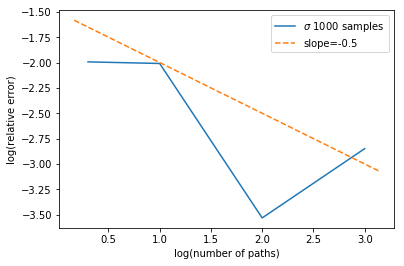

In [95]:
plt.title('')
plt.xlabel('log(number of paths)')
plt.ylabel('log(relative error)')
#for i in range(0, len(num_paths_test)):
#mu_label='$\mu$ ' + str(N_test[-1]) +' samples'
sig_label='$\sigma$ '+ str(N_test[-1]) +' samples'
plt.plot(np.log10(num_paths_test),  np.log10(err_fixeddt_avg[:,-1,1]), label=sig_label)
#plt.plot(np.log10(N_test),  np.log10(err_fixeddt_avg[i,:,1]) , label=sig_label)
abline(-0.5,-1.5)
plt.legend()
plt.savefig('wiener_box_sig_fixedN.pdf')

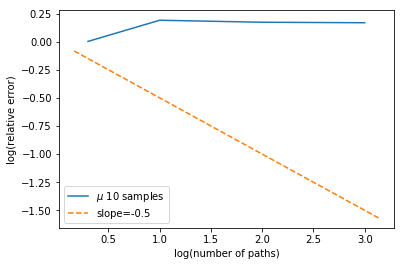

In [96]:
plt.title('')
plt.xlabel('log(number of paths)')
plt.ylabel('log(relative error)')
#for i in range(0, len(num_paths_test)):
mu_label='$\mu$ ' + str(N_test[0]) +' samples'
sig_label='$\sigma$ '+ str(N_test[0]) +' samples'
plt.plot(np.log10(num_paths_test),  np.log10(err_fixeddt_avg[:,0,0]), label=mu_label)
#plt.plot(np.log10(N_test),  np.log10(err_fixeddt_avg[i,:,1]) , label=sig_label)
abline(-0.5,0)
plt.legend()
plt.savefig('wiener_box_mu_fixedN_0.pdf')

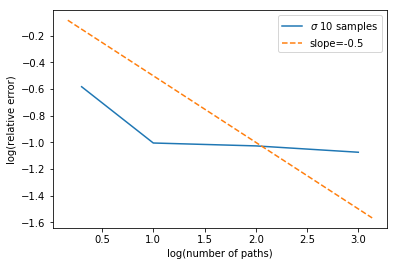

In [97]:
plt.title('')
plt.xlabel('log(number of paths)')
plt.ylabel('log(relative error)')
#for i in range(0, len(num_paths_test)):
#mu_label='$\mu$ ' + str(N_test[-1]) +' samples'
sig_label='$\sigma$ '+ str(N_test[0]) +' samples'
plt.plot(np.log10(num_paths_test),  np.log10(err_fixeddt_avg[:,0,1]), label=sig_label)
#plt.plot(np.log10(N_test),  np.log10(err_fixeddt_avg[i,:,1]) , label=sig_label)
abline(-0.5,-0)
plt.legend()
plt.savefig('wiener_box_sig_fixedN_0.pdf')